# Imports and data

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import SpatialDropout2D


2023-10-20 17:17:18.946286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


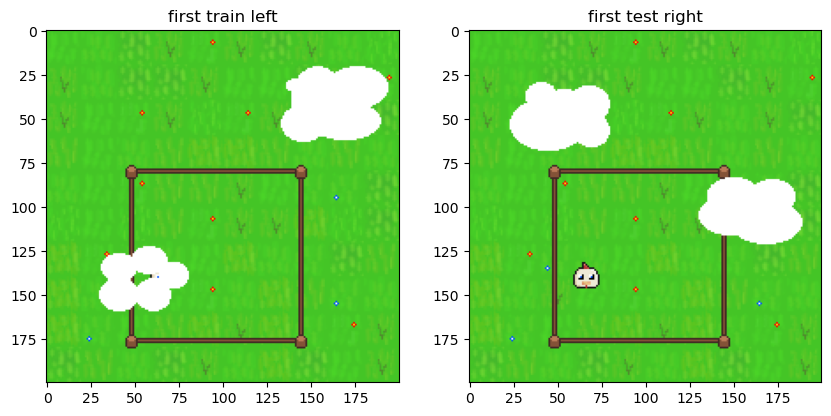

train_imgs shape:  (1000, 200, 200, 3)
test_imgs shape:  (2000, 200, 200, 3)
labels shape:  (499, 2)


In [2]:
# importing data (images)

# ex of path: /home/caria/CCC 2023/level_03/train_data/field000_sample0.png

# this function returns, train_imgs, test_imgs and labels for a given level
def get_data_level(which_level, n_train, n_test):
    # training data
    train_imgs = []
    for i in range(0, n_train):
        if i < 10:
            train_imgs.append(plt.imread('../level_0' + str(which_level) + '/train_data/field00' + str(i) + '_sample0' + '.png'))
            train_imgs.append(plt.imread('../level_0' + str(which_level) + '/train_data/field00' + str(i) + '_sample1' + '.png'))
        elif i < 100:
            train_imgs.append(plt.imread('../level_0' + str(which_level) + '/train_data/field0' + str(i) + '_sample0' + '.png'))
            train_imgs.append(plt.imread('../level_0' + str(which_level) + '/train_data/field0' + str(i) + '_sample1' + '.png'))
        else:
            train_imgs.append(plt.imread('../level_0' + str(which_level) + '/train_data/field' + str(i) + '_sample0' + '.png'))
            train_imgs.append(plt.imread('../level_0' + str(which_level) + '/train_data/field' + str(i) + '_sample1' + '.png'))

        # print
        #print('path:', '../level_0' + str(which_level) + '/train_data/field' + str(i) + '_sample0' + '.png')

    # test data
    test_imgs = []
    for i in range(0, n_test):
        if i < 10:
            test_imgs.append(plt.imread('../level_0' + str(which_level) + '/test_data/field00' + str(i) + '_sample0' + '.png'))
            test_imgs.append(plt.imread('../level_0' + str(which_level) + '/test_data/field00' + str(i) + '_sample1' + '.png'))            
        elif i < 100:
            test_imgs.append(plt.imread('../level_0' + str(which_level) + '/test_data/field0' + str(i) + '_sample0' + '.png'))
            test_imgs.append(plt.imread('../level_0' + str(which_level) + '/test_data/field0' + str(i) + '_sample1' + '.png'))
        else:
            test_imgs.append(plt.imread('../level_0' + str(which_level) + '/test_data/field' + str(i) + '_sample0' + '.png'))
            test_imgs.append(plt.imread('../level_0' + str(which_level) + '/test_data/field' + str(i) + '_sample1' + '.png'))

    # labels
    labels = pd.read_csv('../level_0' + str(which_level) + '/train_data_labels.csv')

    return train_imgs, test_imgs, labels

# testing on level 1

train_imgs, test_imgs, labels = get_data_level(4, 500, 1000)

# checking 1st train, test (train and test side by side) and labels
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(train_imgs[0])
plt.title('first train left')
plt.subplot(1, 2, 2)
plt.imshow(train_imgs[1])
plt.title('first test right')
plt.show()

# labels value barplot
#labels.value_counts().sort_index().plot(kind='bar')
#plt.title('Labels value counts')
#plt.xlabel('Labels')
#plt.ylabel('Counts')
#plt.show()

# shapes
print('train_imgs shape: ', np.array(train_imgs).shape)
print('test_imgs shape: ', np.array(test_imgs).shape)
print('labels shape: ', np.array(labels).shape)


min: 0.0
max: 1.0


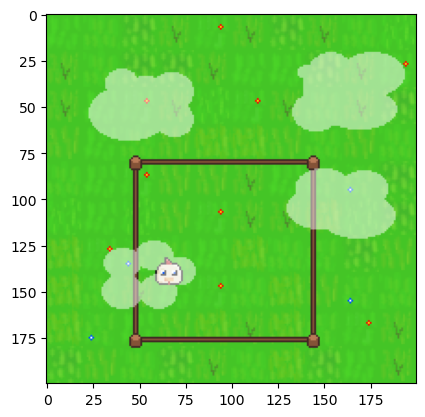

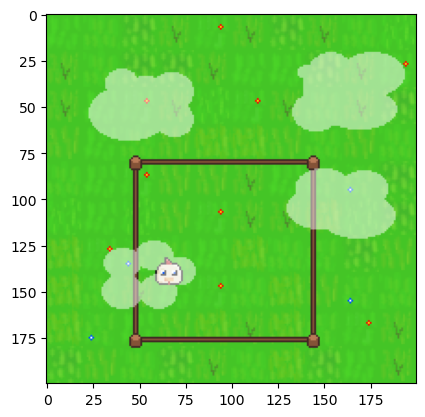

In [3]:
# let's add left (sample0) with right (sample1) images



# trying with first train image
# first though, are they 0-1 normalized?
print('min:', np.min(train_imgs[0]))
print('max:', np.max(train_imgs[0]))

# they are
which = 0
new = train_imgs[2*which] + train_imgs[2*which + 1]
# fitting back into 0-1 range
new = new / np.max(new)

# checking
plt.imshow(new)
plt.show()

# let's make a list with the added images
train_imgs_added = []
for i in range(0, len(train_imgs), 2):
    train_imgs_added.append(train_imgs[i] + train_imgs[i + 1])
    # normalizing back to 0-1 range
    train_imgs_added[i // 2] = train_imgs_added[i // 2] / np.max(train_imgs_added[i // 2])
# checking
plt.imshow(train_imgs_added[0])
plt.show()

# same for test images
test_imgs_added = []
for i in range(0, len(test_imgs), 2):
    test_imgs_added.append(test_imgs[i] + test_imgs[i + 1])
    # normalizing back to 0-1 range
    test_imgs_added[i // 2] = test_imgs_added[i // 2] / np.max(test_imgs_added[i // 2])





Guizão

In [7]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch import optim
from PIL import Image
import os
import csv
import numpy as np

# Define path variables
base_path = '/home/caria/CCC 2023/level_04'
train_data_folder = os.path.join(base_path, 'train_data')
train_label_path = os.path.join(base_path, 'train_data_labels.csv')  # Assuming CSV has 'x,y' for each image pair
test_data_folder = os.path.join(base_path, 'test_data')

# Combine the two cloudy images into a single clearer image
def combine_images(img_path1, img_path2):
    img1 = np.array(Image.open(img_path1).convert('RGB'))
    img2 = np.array(Image.open(img_path2).convert('RGB'))
    combined_img = np.clip(img1 + img2, 0, 255)
    return Image.fromarray(combined_img.astype('uint8'), 'RGB')

# Load the training data
with open(train_label_path, 'r') as f:
    reader = csv.reader(f)
    labels = [list(map(int, row[0].split(','))) for row in reader]

# Process training images
train_image_filenames = sorted(os.listdir(train_data_folder))
train_image_paths = [(os.path.join(train_data_folder, train_image_filenames[i]), os.path.join(train_data_folder, train_image_filenames[i+1])) for i in range(0, len(train_image_filenames), 2)]
train_images = [combine_images(img_pair[0], img_pair[1]) for img_pair in train_image_paths]

# Data loading
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)

        return image, label


# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data into training and validation (80-20 split)
split_idx = int(0.8 * len(train_images))
train_dataset = CustomDataset(train_images[:split_idx], labels[:split_idx], transform=transform)
val_dataset = CustomDataset(train_images[split_idx:], labels[split_idx:], transform=transform)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=16)

# Model (using MobileNetV2 as a regression model)
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.classifier[1] = torch.nn.Linear(model.last_channel, 2)  # Predicting two values, x and y coordinates

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

# Evaluation on validation set
model.eval()
all_predictions = []
all_labels = []
for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
    all_predictions.append(outputs.cpu().numpy())
    all_labels.append(labels.cpu().numpy())

all_predictions = np.vstack(all_predictions)
all_labels = np.vstack(all_labels)
mse_distance = np.mean(np.sum((all_predictions - all_labels)**2, axis=1))
print(f"Mean Squared Euclidean Distance on validation set: {mse_distance}")

# If this is within acceptable limits, you can then proceed to generate predictions for the test set.



Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /home/caria/.cache/torch/hub/v0.6.0.zip
/home/caria/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/caria/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/caria/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:04<00:00, 3.55MB/s]
/home/caria/anaconda3/lib/python3.11/sit

Epoch 1/10 - Loss: 12085.3294


KeyboardInterrupt: 

In [8]:
import torch

print(torch.cuda.is_available())


False


In [9]:
print(f"Training on: {device}")


Training on: cpu


In [ ]:
# Process test images
test_image_filenames = sorted(os.listdir(test_data_folder))
test_image_paths = [(os.path.join(test_data_folder, test_image_filenames[i]), os.path.join(test_data_folder, test_image_filenames[i+1])) for i in range(0, len(test_image_filenames), 2)]
test_images = [combine_images(img_pair[0], img_pair[1]) for img_pair in test_image_paths]

# Create a DataLoader for test images
test_dataset = CustomDataset(test_images, [0]*len(test_images), transform=transform)  # labels are not used
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)

# Predict on test set
model.eval()
test_predictions = []

for images, _ in test_loader:  # we don't need labels for test data
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
    test_predictions.append(outputs.cpu().numpy())

test_predictions = np.vstack(test_predictions)

# Save the predictions to a CSV file
with open('test_predictions.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['x', 'y'])
    writer.writerows(test_predictions)

print("Test predictions saved to test_predictions.csv")

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch import optim
from PIL import Image
import os
import csv
import numpy as np

# Data loading
class CustomDataset(Dataset):
    def _init_(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def _len_(self):
        return len(self.images)

    def _getitem_(self, idx):
        image = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Process training images

train_images = train_imgs_added

# Process testing images

test_images = test_imgs_added



# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data into training and validation (80-20 split)
split_idx = int(0.8 * len(train_images))
train_dataset = CustomDataset(train_images[:split_idx], labels[:split_idx], transform=transform)
val_dataset = CustomDataset(train_images[split_idx:], labels[split_idx:], transform=transform)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=16)

# Model (using MobileNetV2 as a regression model)
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.classifier[1] = torch.nn.Linear(model.last_channel, 2)  # Predicting two values, x and y coordinates

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

# Evaluation on validation set
model.eval()
all_predictions = []
all_labels = []
for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
    all_predictions.append(outputs.cpu().numpy())
    all_labels.append(labels.cpu().numpy())

all_predictions = np.vstack(all_predictions)
all_labels = np.vstack(all_labels)
mse_distance = np.mean(np.sum((all_predictions - all_labels)**2, axis=1))
print(f"Mean Squared Euclidean Distance on validation set: {mse_distance}")

# If this is within acceptable limits, you can then proceed to generate predictions for the test set.

TypeError: CustomDataset() takes no arguments

# Preprocessing

# Classfication: 2nd try

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D

# Convert images and labels to arrays
train_imgs = np.array(train_imgs)
labels = np.array(labels)

# Define KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

val_acc_list = []

for train_index, val_index in kf.split(train_imgs):
    
    train, train_labels = train_imgs[train_index], labels[train_index]
    val, val_labels = train_imgs[val_index], labels[val_index]
    
    # Model definition
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(SpatialDropout2D(0.25))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(SpatialDropout2D(0.25))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Training
    model.fit(train, train_labels, epochs=10, batch_size=32, validation_data=(val, val_labels))
    
    # Evaluating accuracy
    _, val_acc = model.evaluate(val, val_labels)
    val_acc_list.append(val_acc)
    
    # Confusion matrix
    preds = model.predict(val)
    preds

    

Epoch 1/10
3/3 [==============================] - 3s 720ms/step - loss: 1.6604 - accuracy: 0.5823 - val_loss: 0.5533 - val_accuracy: 0.8000
Epoch 2/10
3/3 [==============================] - 2s 644ms/step - loss: 0.7736 - accuracy: 0.6076 - val_loss: 0.5644 - val_accuracy: 0.8000
Epoch 3/10
3/3 [==============================] - 2s 661ms/step - loss: 0.6520 - accuracy: 0.6582 - val_loss: 0.5788 - val_accuracy: 0.8000
Epoch 4/10
3/3 [==============================] - 2s 736ms/step - loss: 0.6089 - accuracy: 0.6582 - val_loss: 0.5055 - val_accuracy: 0.8000
Epoch 5/10
3/3 [==============================] - 2s 689ms/step - loss: 0.5899 - accuracy: 0.6962 - val_loss: 0.5996 - val_accuracy: 0.8000
Epoch 6/10
3/3 [==============================] - 2s 717ms/step - loss: 0.5571 - accuracy: 0.6835 - val_loss: 0.5260 - val_accuracy: 0.8000
Epoch 7/10
3/3 [==============================] - 2s 651ms/step - loss: 0.4480 - accuracy: 0.7722 - val_loss: 0.5810 - val_accuracy: 0.7500
Epoch 8/10
3/3 [====

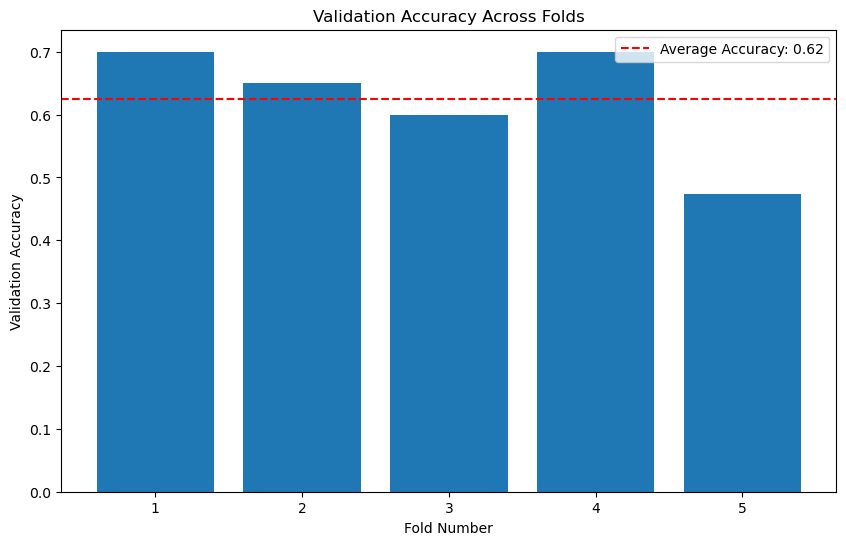

In [ ]:
avg_val_acc = np.mean(val_acc_list)

# Plotting average accuracy across all folds
plt.figure(figsize=(10,6))
plt.bar(range(1, len(val_acc_list)+1), val_acc_list)
plt.xlabel('Fold Number')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Across Folds')
plt.xticks(range(1, len(val_acc_list)+1))
plt.axhline(avg_val_acc, color='red', linestyle='--', label=f"Average Accuracy: {avg_val_acc:.2f}")
plt.legend()
plt.show()


In [ ]:
# checking confusion matrix and val accuracy

val_acc_list

np.mean(val_acc_list)

preds = preds.reshape(19,)
preds = np.round(preds)
confusion_matrix(val_labels, preds)


array([[ 0, 10],
       [ 0,  9]])

# Results

In [ ]:

# let's print out the results for the given CNN architecture used

# 1st Convolutional Layer
print('1st Convolutional Layer')
print('Number of filters: 32')
print('Filter size: 3x3')
print('Activation function: relu')
print('Input shape: 200x200x3')
print('Max pooling: 2x2')
print('')
# 2nd Convolutional Layer
print('2nd Convolutional Layer')
print('Number of filters: 64')
print('Filter size: 3x3')
print('Activation function: relu')
print('Max pooling: 2x2')
print('')
# 3rd Convolutional Layer
print('3rd Convolutional Layer')
print('Number of filters: 128')
print('Filter size: 3x3')
print('Activation function: relu')
print('Max pooling: 2x2')
print('')
# Fully Connected Layer
print('Fully Connected Layer')
print('Number of neurons: 128')
print('Activation function: relu')
print('Dropout: 0.5')
print('')
# Output Layer
print('Output Layer')
print('Number of neurons: 1')
print('Activation function: sigmoid')
# Optimizer, type of loss function and metrics
print('')
print('Optimizer: adam')
print('Loss function: binary_crossentropy')
print('Metrics: accuracy')
# Epochs, batch size and validation data
print('')
print('Epochs: 10')
print('Batch size: 32')
print('Validation data: 20%')

# let's print out the results for the given CNN architecture used

# Accuracy and Loss
print('')
print('Accuracy: 0.6316')
print('Loss: 0.9684')


1st Convolutional Layer
Number of filters: 32
Filter size: 3x3
Activation function: relu
Input shape: 200x200x3
Max pooling: 2x2

2nd Convolutional Layer
Number of filters: 64
Filter size: 3x3
Activation function: relu
Max pooling: 2x2

3rd Convolutional Layer
Number of filters: 128
Filter size: 3x3
Activation function: relu
Max pooling: 2x2

Fully Connected Layer
Number of neurons: 128
Activation function: relu
Dropout: 0.5

Output Layer
Number of neurons: 1
Activation function: sigmoid

Optimizer: adam
Loss function: binary_crossentropy
Metrics: accuracy

Epochs: 10
Batch size: 32
Validation data: 20%

Accuracy: 0.6316
Loss: 0.9684


# Might use

In [ ]:
# predictions for the 2nd try classification

'''
# Assuming test_imgs is your test dataset
test_predictions = model.predict(np.array(test_imgs))
test_predictions = np.round(test_predictions).flatten()

# Saving the model
model.save('my_model.h5')

# Loading the model
from tensorflow.keras.models import load_model
loaded_model = load_model('my_model.h5')
'''

In [ ]:
''' 
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

# Create a function to define and compile the model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(SpatialDropout2D(0.25))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(SpatialDropout2D(0.25))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

'''


In [ ]:
# for predicting the test data
'''
predictions = model.predict(test_imgs)
predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

# Save the predicted labels to a file
with open("predictions.txt", "w") as f:
    for label in predicted_labels:
        f.write(str(label) + '\n')
'''

'\npredictions = model.predict(test_imgs)\npredicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]\n\n# Save the predicted labels to a file\nwith open("predictions.txt", "w") as f:\n    for label in predicted_labels:\n        f.write(str(label) + \'\n\')\n'

In [ ]:
# old

'''
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
'''

"\nmodel = Sequential([\n    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),\n    MaxPooling2D(2, 2),\n    Conv2D(64, (3, 3), activation='relu'),\n    MaxPooling2D(2, 2),\n    Conv2D(128, (3, 3), activation='relu'),\n    MaxPooling2D(2, 2),\n    Flatten(),\n    Dense(512, activation='relu'),\n    Dropout(0.5),\n    Dense(1, activation='sigmoid')\n])\n\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n"